Install Dependencies

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 12.4 MB/s 
     |████████████████████████████████| 6.3 MB 42.0 MB/s 
     |████████████████████████████████| 15.4 MB 19.0 MB/s 


Import Statements

In [ ]:
from google.colab import files
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium 
import numpy as np
import json
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# **Part 1: Data Collection**

To follow along with the tutorial, you can access the datasets and notebook from https://github.com/rad1200/rad1200.github.io

Since we utilize multiple datasets in this tutorial, there will be a little bit of data cleaning in this section as well so that each dataset is in a clearly formatted dataframe and there's a basic level of consistency among the datasets. More in depth data cleaning will occur in the next part. 

The first dataset we are using is from the Washington Post Database of Fatal Police Shootings from January 1st, 2015 to December 5th, 2021 posted on github (https://github.com/washingtonpost/data-police-shootings). We store it in shootingdf which we will later be modifying based on our other datasets.

For clarity purposes we replace the one letter race identifiers with the race names and also replace any NaN values with unknown (for consistency across the dataframe).

In [ ]:
shootingdf=pd.read_csv("fatal_shootings.csv")
shootingdf= shootingdf.replace({'A': 'Asian', 'W':'White','B':'Black', 'N':'Native', 'H':'Hispanic', 'O':'Other', np.nan : 'Unknown'})
shootingdf.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53,M,Asian,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47,M,White,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32,M,White,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


Note that the shootingdf has states listed as two letter state codes. Since we want to identify states by their state codes in our other datasets the way they are identified in the shootingdf, we will be utilizing the state_codes dictionary to do so (utilized the following dicitionary as reference: https://gist.github.com/rogerallen/1583593).

In [ ]:
state_codes = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "Puerto Rico": "PR",
}

Will be using the following csv file that contains all 50 states' (as well as DC and Puerto Rico's) population percentage of each race (https://worldpopulationreview.com/states/states-by-race). This csv will be used to to correlate the states and percentages of each race within them with the number of shootings of each race per state.

Something important to note is that this dataset does not treat Hispanics as a separate race and has Hawaiians as a separate race unlike the fatal shootings dataset. We chose the version of the dataset which had percent of each race that does not also identify as Hispanic listed to align with the shooting data. However, due to these differences, the "Other" column in both datasets do not necessarily mean the same thing. We consolidate these differences by dropping the columns with Non-Hispanic Hawaiian's Percentages and the "Other" column in this dataset. In summary, we will be going back to the fatal shooting data in shootingdf and excluding any shootings where race is listed as Hispanic, Other, or Unknown.

Here we load the state race data csv into a dataframe. We then add a state codes column, rename columns for the Race Percentages to just the Race name, and drop the Hawaiian and Other percentage columns.

In [ ]:
racestate=pd.read_csv("stateRaceData.csv")
racestate['StateCode']= racestate['State'].map(state_codes)
cols=racestate.columns.tolist()
cols=cols[0:1]+ cols[-1:]+cols[1:-1]
racestate=racestate[cols]
racestate.rename(columns={"WhiteNonHispanicPerc": "White", "BlackNonHispanicPerc": "Black","IndianNonHispanicPerc":"Native","AsianNonHispanicPerc":"Asian"},inplace = True)
racestate.drop("HawaiianNonHispanicPerc", axis=1,inplace=True)
racestate.drop("OtherNonHispanicPerc", axis=1,inplace=True)
racestate.head()

,State,StateCode,White,Black,Native,Asian
0,Alabama,AL,0.6552,0.2649,0.0047,0.0134
1,Alaska,AK,0.6063,0.0310,0.1442,0.0609
2,Arizona,AZ,0.5471,0.0421,0.0392,0.0321
3,Arkansas,AR,0.7243,0.1523,0.0059,0.0150
4,California,CA,0.3718,0.0552,0.0036,0.1428


To better put these percentages in context (and for later data analysis), we want to include the total population for each state. This information was found in the following dataset found here: https://worldpopulationreview.com/states. We just want the population counts so we will add the column with this information from this dataset into the racestate dataframe.

In [ ]:
#do above
statepop=pd.read_csv("statePop.csv")
racestate=pd.merge(racestate, statepop, on=["State"])
racestate=racestate.drop(["Growth","Pop2018","rank","Pop2010","growthSince2010","Percent","density"], axis=1)
racestate.head()

,State,StateCode,White,Black,Native,Asian,Pop
0,Alabama,AL,0.6552,0.2649,0.0047,0.0134,4934193
1,Alaska,AK,0.6063,0.0310,0.1442,0.0609,724357
2,Arizona,AZ,0.5471,0.0421,0.0392,0.0321,7520103
3,Arkansas,AR,0.7243,0.1523,0.0059,0.0150,3033946
4,California,CA,0.3718,0.0552,0.0036,0.1428,39613493


Next we go back and clean shootingdf so it only includes rows where race is Asian, Black, White or Native.

In [ ]:
drop_h=shootingdf.race != "Hispanic"
drop_o=shootingdf.race != "Other"
drop_u=shootingdf.race != "Unknown"
drop_irr=drop_h & drop_o & drop_u
shootingdf=shootingdf[drop_irr]
shootingdf

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53,M,Asian,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47,M,White,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32,M,White,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
5,11,Kenneth Joe Brown,2015-01-04,shot,gun,18,M,White,Guthrie,OK,False,attack,Not fleeing,False,-97.423,35.877,True
7,15,Brock Nichols,2015-01-06,shot,gun,35,M,White,Assaria,KS,False,attack,Not fleeing,False,-97.564,38.704,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,7205,Alexander King,2021-10-16,shot,toy weapon,17,M,White,Tarpon Springs,FL,False,attack,Not fleeing,False,-82.757,28.148,True
6696,7214,Joshua Dewayne Hammock,2021-10-16,shot,knife,30,M,White,Estero,FL,False,attack,Unknown,False,-81.783,26.433,True
6704,7236,Unknown,2021-10-19,shot,gun,Unknown,M,White,Pensacola,FL,False,attack,Not fleeing,False,-87.254,30.418,True
6754,7364,Unknown,2021-11-14,shot,gun,30,M,Black,Columbia,MO,False,attack,Foot,False,Unknown,Unknown,True


Next we utilize a dataset which contains all the Black Lives Matter (BLM) protests that occurred between June and November of 2020. The dataset was a javascript file with a variable set to a json object which was extracted into a new file manually (https://www.creosotemaps.com/blm2020/json/2020_1118_1.js). 


The Black Lives Matter Movement began back in 2013, primarily on social media in response to the acquittal of George Zimmerman, a police officer, for the shooting of Trayvon Martin, an African American teenager.

Due to the outrage and sadness caused by George Floyd's murder under police custody on May 25, 2020, protests began all over the U.S. in the months that followed. Our dataset includes protests from June 2020 to November 2020 which covers the months following the murder til the month following Floyd's birthday in October. There is not data available after November 2020 of BLM protests but the months covered in the Dataset cover the peak months of the 2020 BLM protests. To read more about the protests and movement, here are some resources:

*   https://www.theweek.in/news/world/2020/12/26/black-lives-matter-timeline.html
*   https://library.law.howard.edu/civilrightshistory/BLM



Even after getting the javascript file into json format, the data was messy so instead of using pandas's read json function directory, we created a dictionary of the occurrence of each state that we have the race percentages data for.

In [ ]:
f = open("BLMprotests.json",encoding="utf8")
jobject=json.load(f)
#the states we will focus on are the ones we have population percentages for
states=racestate["State"].tolist() 
stateDict=dict.fromkeys(states,0)

#goes through json file increments number of protests for each state in dictionary 
#and builds dataframe from the dictionary
for i in range(0,len(jobject['features'])):
  reg=jobject['features'][i]['properties']['Region']
  if reg in stateDict.keys():
    stateDict[reg]=stateDict[reg]+1
protests_states=pd.DataFrame.from_dict(stateDict,orient='index')

#renames columns for generated dataframe and adds a StateCode column
protests_states=protests_states.reset_index()
protests_states = protests_states.rename({'index': 'State', 0: 'Num_Protests'}, axis='columns')
protests_states['StateCode']= protests_states['State'].map(state_codes)
cols=protests_states.columns.tolist()
cols=cols[0:1]+ cols[-1:]+cols[1:-1]
protests_states=protests_states[cols]
protests_states.head()

,State,StateCode,Num_Protests
0,Alabama,AL,48
1,Alaska,AK,25
2,Arizona,AZ,40
3,Arkansas,AR,35
4,California,CA,387


# **Our Focus**

Now that we had extracted the information necessary from all 4 datasets, we would like to discuss what are goals are with this data.

In general, we would like to know the relationship between the BLM protests in each state and the police shootings of Black Americans that have occurred in those states.

First, we will dive into the distribution of fatal shootings across races for each of the states. We are interested in seeing which states have a high number of fatal shootings and further, the distribution of races over these shootings as well as which states have a high number of fatal shootings for each race individually.

Additionally, we will investigate the Black Lives Matter protests that occurred within each state and analyze the relationship between the number of protests in each state and the shootings that have occurred there.

Lastly, we plan to create machine learning models to see if we can predict the number of protests and the number of Black Americans killed following the start of the protests in a given state.

# **Part 2.0: First Set of Data Tidying and Visualizations**

We will begin by looking at the fatal shooting data in a more broad sense and doing some visualizations before narrowing in our focus. We first want to investigate the distribution of races killed across the states. In order to do this, we will be utilizing data from both the racesate dataframe as well as the fatal shootings dataframe as they both contain relevant information regarding the state's population, distribution of races, and distribution of fatal shootings for each race.

For this part we will be utilizing a dataframe called dfA, in order to preserve the data as it was collected in Part 1. First we will begin by having dfA be a copy of the racestate dataframe so that it includes the state name, state code, percentage makeup of each race in the state, and state population.

In [ ]:
dfA=racestate.copy()
dfA.head()

,State,StateCode,White,Black,Native,Asian,Pop
0,Alabama,AL,0.6552,0.2649,0.0047,0.0134,4934193
1,Alaska,AK,0.6063,0.0310,0.1442,0.0609,724357
2,Arizona,AZ,0.5471,0.0421,0.0392,0.0321,7520103
3,Arkansas,AR,0.7243,0.1523,0.0059,0.0150,3033946
4,California,CA,0.3718,0.0552,0.0036,0.1428,39613493


Next for each state we will add a column for the total number of people who were shot by police in that state using the data from the shootingdf dataframe that was extracted in part 1.

In [ ]:
statecounts=shootingdf.groupby(['state']).size()
for s in statecounts.keys():
  dfA.loc[dfA['StateCode'] == s, 'total_killed']=statecounts[s]

dfA.head() 

,State,StateCode,White,Black,Native,Asian,Pop,total_killed
0,Alabama,AL,0.6552,0.2649,0.0047,0.0134,4934193,109.0
1,Alaska,AK,0.6063,0.0310,0.1442,0.0609,724357,43.0
2,Arizona,AZ,0.5471,0.0421,0.0392,0.0321,7520103,155.0
3,Arkansas,AR,0.7243,0.1523,0.0059,0.0150,3033946,85.0
4,California,CA,0.3718,0.0552,0.0036,0.1428,39613493,455.0


Next, to gather the number of people killed for each race per state we group shootingdf by state and race and get the count for each combination. We then add the columns NumWhiKilled, NumBlaKilled, NumAsiKilled, and NumNatKilled which have the raw numbers of how many people of each race were killed per state to their respective state rows in dfA.

In [ ]:
stateracecounts=shootingdf.groupby(['state','race']).size()
new=(pd.DataFrame(np.zeros((len(dfA.index), 4))))
dfA=dfA.assign(NumWhiKilled=new[0], NumBlaKilled=new[1],NumAsiKilled=new[2], NumNatKilled=new[3])
racetokilled={'White':'NumWhiKilled','Black':'NumBlaKilled','Asian':'NumAsiKilled','Native':'NumNatKilled'}
for s in stateracecounts.keys():
    racerow=racetokilled[s[1]]
    dfA.loc[dfA.StateCode==s[0], racerow]=stateracecounts[s]
dfA.head()

,State,StateCode,White,Black,Native,Asian,Pop,total_killed,NumWhiKilled,NumBlaKilled,NumAsiKilled,NumNatKilled
0,Alabama,AL,0.6552,0.2649,0.0047,0.0134,4934193,109.0,72.0,37.0,0.0,0.0
1,Alaska,AK,0.6063,0.0310,0.1442,0.0609,724357,43.0,28.0,3.0,2.0,10.0
2,Arizona,AZ,0.5471,0.0421,0.0392,0.0321,7520103,155.0,120.0,22.0,0.0,13.0
3,Arkansas,AR,0.7243,0.1523,0.0059,0.0150,3033946,85.0,57.0,26.0,2.0,0.0
4,California,CA,0.3718,0.0552,0.0036,0.1428,39613493,455.0,258.0,158.0,35.0,4.0


To put this data we have so far into context, we create a stacked bar plot of the Top 10 States that had the highest total police shootings (where the totals include shootings of White, Black, Asian, and Native Americans). This stacked bar plot shows the breakdown for each race within each state's total. 

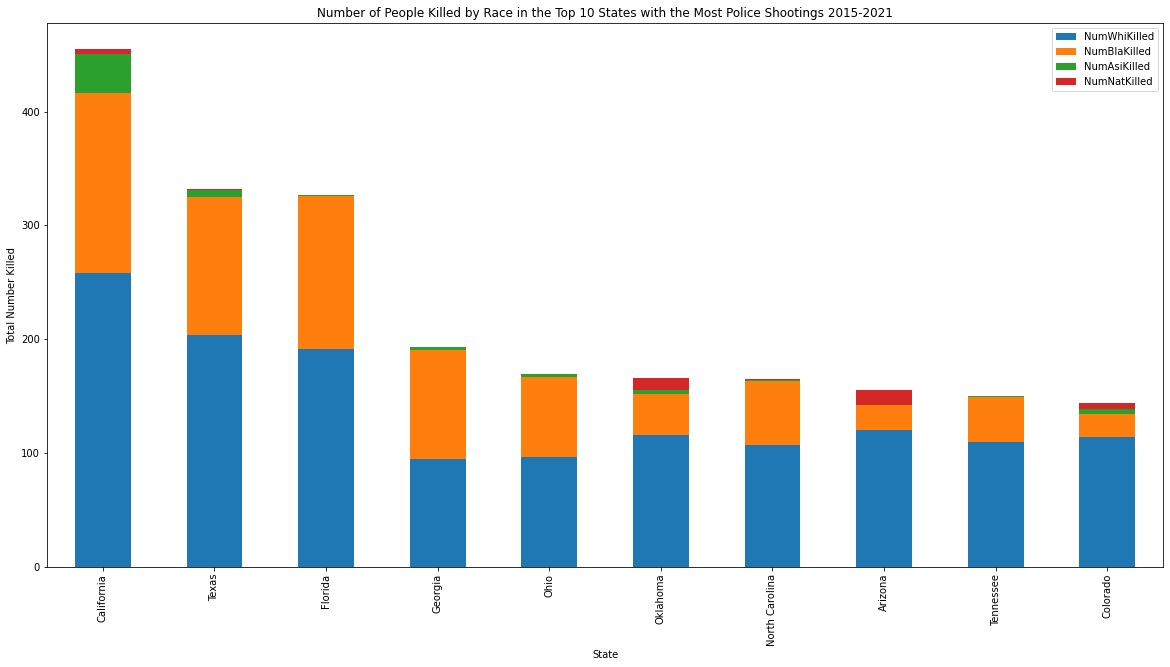

In [ ]:
dfA.sort_values(by = ["total_killed"], inplace=True, ascending=False)
toptentot=dfA.head(10)
toptentot.plot.bar(x="State", y=["NumWhiKilled","NumBlaKilled","NumAsiKilled","NumNatKilled"], stacked=True, title ="Number of People Killed by Race in the Top 10 States with the Most Police Shootings 2015-2021",ylabel="Total Number Killed",figsize=(20,10) ).legend(loc = 'best')

Looking at the bar plot above, it seems like a simple conclusion is that white people are the ones who have been killed the most in police shootings. At least in the case of the top 10 states for police shootings, this is consistent across the board.

However, the plot doesn't give us a truly accurate representation of the relationship of race to number of fatal police shootings across the United States. This is due to the fact that each state has a varied distribution of races in their population.

To get a clearer picture of which race is seemingly targeted the most in each state, we create columns with a new metric: the proportion of each race killed by fatal police shootings for each race in the state. We create this metric by dividing the number of people killed for each race per state by the number of people of that race (state population multiplied by percent of Race in that state). This proportion will put the number of people killed per race for each state in context with the population size and percentage of race for the state, giving us a more accurate representation of the distribution of fatal shootings.

In [ ]:
dfA.sort_index(inplace=True)
dfA['PropWhiKilled']=dfA['NumWhiKilled']/(dfA["Pop"]*dfA['White'])
dfA['PropBlaKilled']=dfA['NumBlaKilled']/(dfA["Pop"]*dfA['Black'])
dfA['PropAsiKilled']=dfA['NumAsiKilled']/(dfA["Pop"]*dfA['Asian'])
dfA['PropNatKilled']=dfA['NumNatKilled']/(dfA["Pop"]*dfA['Native'])
dfA.head()

,State,StateCode,White,Black,Native,Asian,Pop,total_killed,NumWhiKilled,NumBlaKilled,NumAsiKilled,NumNatKilled,PropWhiKilled,PropBlaKilled,PropAsiKilled,PropNatKilled
0,Alabama,AL,0.6552,0.2649,0.0047,0.0134,4934193,109.0,72.0,37.0,0.0,0.0,0.000022,0.000028,0.000000,0.000000
1,Alaska,AK,0.6063,0.0310,0.1442,0.0609,724357,43.0,28.0,3.0,2.0,10.0,0.000064,0.000134,0.000045,0.000096
2,Arizona,AZ,0.5471,0.0421,0.0392,0.0321,7520103,155.0,120.0,22.0,0.0,13.0,0.000029,0.000069,0.000000,0.000044
3,Arkansas,AR,0.7243,0.1523,0.0059,0.0150,3033946,85.0,57.0,26.0,2.0,0.0,0.000026,0.000056,0.000044,0.000000
4,California,CA,0.3718,0.0552,0.0036,0.1428,39613493,455.0,258.0,158.0,35.0,4.0,0.000018,0.000072,0.000006,0.000028


In [ ]:
dfA.sort_values(by = ["PropWhiKilled"], inplace=True, ascending=False)
dfA.head()

,State,StateCode,White,Black,Native,Asian,Pop,total_killed,NumWhiKilled,NumBlaKilled,NumAsiKilled,NumNatKilled,PropWhiKilled,PropBlaKilled,PropAsiKilled,PropNatKilled
1,Alaska,AK,0.6063,0.0310,0.1442,0.0609,724357,43.0,28.0,3.0,2.0,10.0,0.000064,0.000134,0.000045,0.000096
36,Oklahoma,OK,0.6563,0.0714,0.0726,0.0214,3990443,166.0,116.0,36.0,3.0,11.0,0.000044,0.000126,0.000035,0.000038
31,New Mexico,NM,0.3739,0.0181,0.0874,0.0145,2105005,32.0,28.0,2.0,0.0,2.0,0.000036,0.000052,0.000000,0.000011
26,Montana,MT,0.8609,0.0044,0.0607,0.0077,1085004,37.0,32.0,0.0,0.0,5.0,0.000034,0.000000,0.000000,0.000076
28,Nevada,NV,0.4923,0.0874,0.0091,0.0799,3185786,68.0,47.0,17.0,3.0,1.0,0.000030,0.000061,0.000012,0.000034


To get an idea of in which states the highest proportion of a certain race are being killed by police shootings, we create bar plots for each race (White, Black, Asian, and Native). Each bar plot shows the 10 states where the highest proportion of that race is killed given how much they make up of the state population.

With this, we would like to see which states are consistently appearing in the top 10 across the different races.

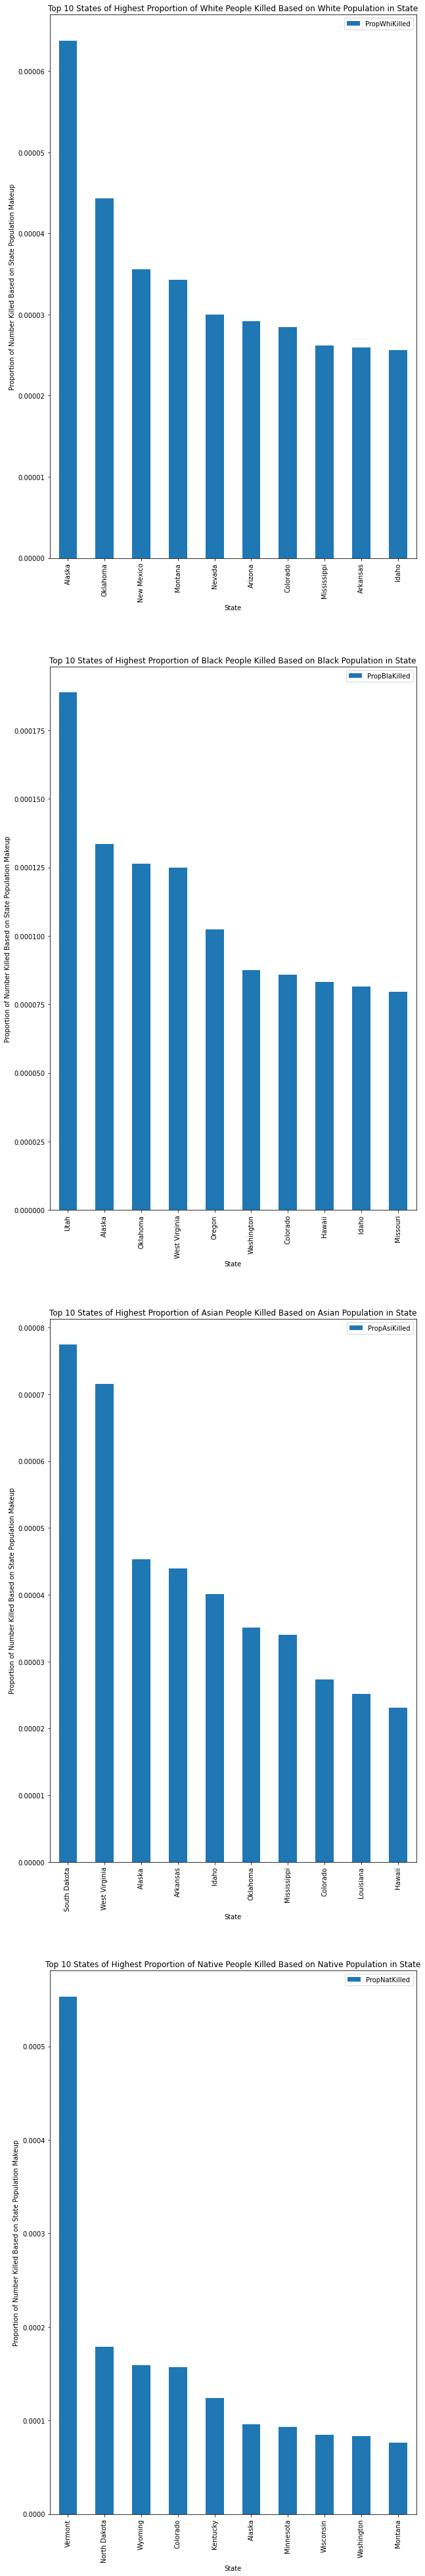

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(10,70),sharex=False)
listaxis= axs.flatten()

#Proportion White Killed
dfA.sort_values(by = ["PropWhiKilled"], inplace=True, ascending=False)
toptenwhi=dfA.head(10)
toptenwhi.plot(ax=axs[0], kind='bar', x='State',y='PropWhiKilled', xlabel="State", ylabel="Proportion of Number Killed Based on State Population Makeup", title="Top 10 States of Highest Proportion of White People Killed Based on White Population in State")
axs[0].get_yaxis().get_major_formatter().set_scientific(False)

dfA.sort_values(by = ["PropBlaKilled"], inplace=True, ascending=False)
toptenbla=dfA.head(10)
toptenbla.plot(ax=axs[1], kind='bar', x='State',y='PropBlaKilled', xlabel="State", ylabel="Proportion of Number Killed Based on State Population Makeup", title="Top 10 States of Highest Proportion of Black People Killed Based on Black Population in State")
axs[1].get_yaxis().get_major_formatter().set_scientific(False)

dfA.sort_values(by = ["PropAsiKilled"], inplace=True, ascending=False)
toptenasi=dfA.head(10)
toptenasi.plot(ax=axs[2], kind='bar', x='State',y='PropAsiKilled', xlabel="State", ylabel="Proportion of Number Killed Based on State Population Makeup", title="Top 10 States of Highest Proportion of Asian People Killed Based on Asian Population in State")
axs[2].get_yaxis().get_major_formatter().set_scientific(False)

dfA.sort_values(by = ["PropNatKilled"], inplace=True, ascending=False)
toptennat=dfA.head(10)
toptennat.plot(ax=axs[3], kind='bar', x='State',y='PropNatKilled', xlabel="State", ylabel="Proportion of Number Killed Based on State Population Makeup", title="Top 10 States of Highest Proportion of Native People Killed Based on Native Population in State")
axs[3].get_yaxis().get_major_formatter().set_scientific(False)

Looking across the 4 graphs, only Alaska appears as a top 10 state consistently. Additionally, states like Idaho, Oklahoma, and Colorado were in the top 10 for 3 out of the 4 races. This could be an indicator that some states just have a higher tendency for police shootings regardless of race.

However, is the same proportion of each race killed for all these states? The below barplots will take a closer look at Alaska, Oklahoma, Idaho, and Colorado to see whether the proportions of each race being killed is similar across these states or not.

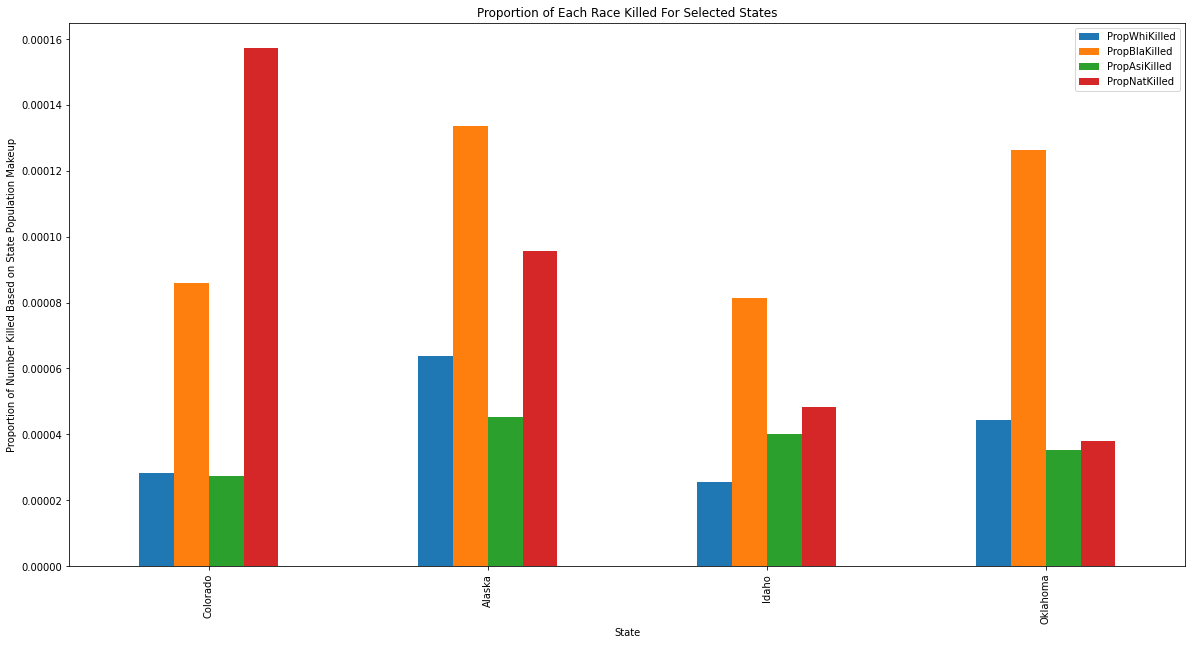

In [ ]:
shootheavystates=dfA[dfA['StateCode'].isin(['CO', 'OK', 'ID','AK'])]
shootheavystates.plot.bar(x="State", y=["PropWhiKilled","PropBlaKilled","PropAsiKilled","PropNatKilled"], stacked=False, title="Proportion of Each Race Killed For Selected States",ylabel="Proportion of Number Killed Based on State Population Makeup",figsize=(20,10) ).legend(loc = 'best')

Looking at the graph above it's clear that while all of these states are among the top 10 for all or most of the races' highest proportion killed, the proportion of each race killed for these states is not the same. In particular, Black and Native Americans were killed at generally higher proportions than White or Asian Americans.

In the next section, we will be delving into the number of BLM protests per state and relating that to the proportion of Black Americans killed. These graphs confirm that Black Americans are killed at high proportions at higher rates than some of the other races. Lastly, while we won't be looking further at the proportion of Native Americans killed in police shootings based on state population, further exploration can and should be done in the future.

# **Part 2.1: Second Set of Data Tidying and Visualizations**

We will now narrow our focus to looking at the proportion of Black Americans killed in each state and how this may relate to the BLM protests data. We ultimately want to make conclusions on the relationship between the number of BLM protests and the number of shootings of Black Americans in 2020 and 2021. 

First, however, we will take a look at how the number of shootings of Black Americans has been changing across the years.

In [ ]:
#get states where the most Black Americans were killed
dfA.sort_values(by = ["NumBlaKilled"], inplace=True, ascending=False)
top10states=dfA.head(10)["StateCode"]
top10states

4     CA
9     FL
44    TX
10    GA
35    OH
18    LA
13    IL
20    MD
25    MO
33    NC
Name: StateCode, dtype: object

In [ ]:
#from shootingdf we extract the columns of Black Americans being killed in police 
#shootings in any of the top 10 states for Black Americans being killed by police
#shootings 2015-2021
shootingdf['date']=pd.to_datetime(shootingdf['date'])
cond1=(shootingdf['race']=="Black")
onlyblakilled=shootingdf.loc[cond1]
onlyblakilled=onlyblakilled[onlyblakilled['state'].isin(top10states)]

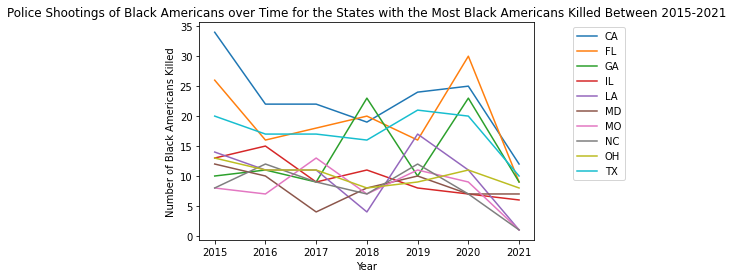

In [ ]:
#want to plot the number killed per state per year
fig, ax = plt.subplots()
statyeargrouped=onlyblakilled.groupby(['state', onlyblakilled.date.dt.year])
stateyears=statyeargrouped.size().to_frame(name = 'size').reset_index()
statesgrouped=stateyears.groupby(['state'])

for s in statesgrouped.groups.keys():
  astate = statesgrouped.get_group(s)
  astate.plot(x = 'date', y = 'size', ax=ax, legend = True, label = s, 
            title = "Police Shootings of Black Americans over Time for the States with the Most Black Americans Killed Between 2015-2021", xlabel = "Year", ylabel = "Number of Black Americans Killed" )
ax.legend(bbox_to_anchor=(1.1, 1.00))

plt.show()


The above line plot shows a sharp decline in number of Black Americans from the peaks in 2020 for many of the states such; notably Florida, Georgia, California and Texas. Something to note is that during the protests themselves, many armed police officers were present to combat these protests which could explain how there was a peak in 2020. 

However, in 2021 we can see some of the lowest numbers of Black Americans killed by police shootings in these states. In fact, Minnesota, Louisiana, and North Carolina, which all have a relatively consistent number of shootings over the years all decreased to a total of 1 fatal shooting of Black Americans in the year 2021. This could suggest that the BLM protests truly did have an effect on the number of police shootings of Black Americans. We will explore this hypothesis more directly in our hypothesis testing section. 

With that in mind, we would like to create some visualizations that help relate the number of BLM protests and how many Black Americans were murdered in police shootings.

We begin with dataframe dfB, a copy of protests_states that includes the states, their statecode, and the number of protests per state.

In [ ]:
dfB=protests_states.copy()
dfB.head()

,State,StateCode,Num_Protests
0,Alabama,AL,48
1,Alaska,AK,25
2,Arizona,AZ,40
3,Arkansas,AR,35
4,California,CA,387


To get a better idea of the data we will plot the top 10 states with the most number of BLM protests (for the dataset time from of June-November 2020).

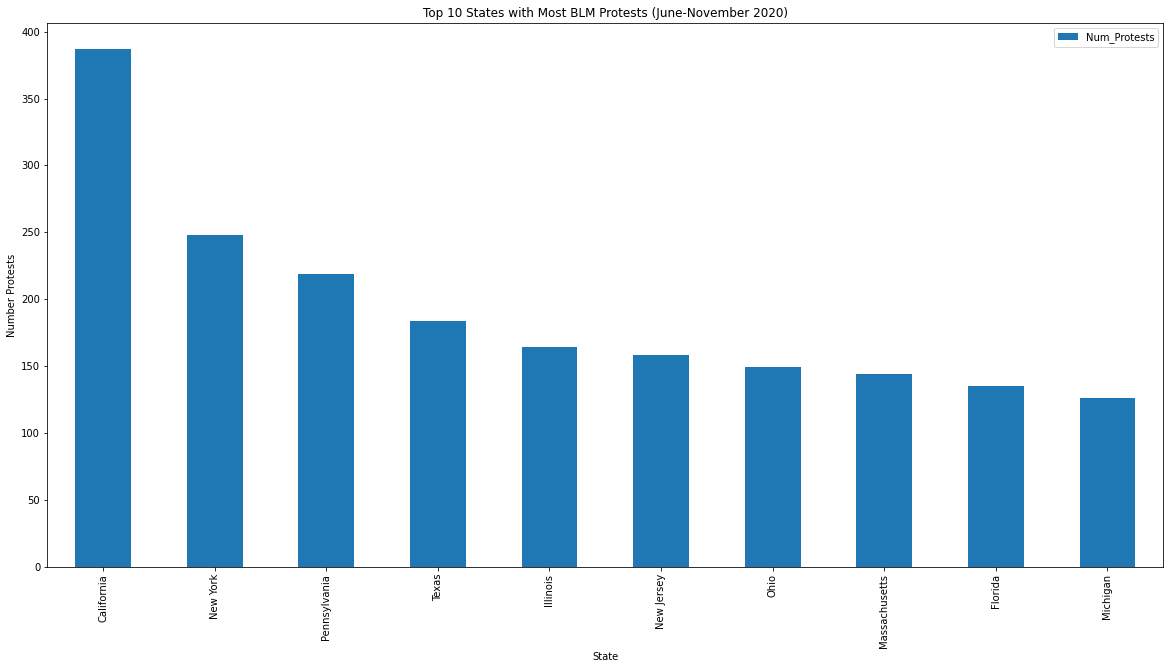

In [ ]:
dfB.sort_values(by = ["Num_Protests"], inplace=True, ascending=False)
toptenpro=dfB.head(10)
toptenpro.plot.bar(x="State", y="Num_Protests", title="Top 10 States with Most BLM Protests (June-November 2020)",ylabel="Number Protests",figsize=(20,10) ).legend(loc = 'best')

From the bar plot above, we can observe that California had far more protests that the state with the second highest number of protests, New York. This is interesting to note considering how populous California is. In addition to this, it is interesting to note that California, Texas, and Florida (3 of the 4 states that were noted to have a large decrease in number of fatal Black American shootings from 2020 to 2021) are in the top 10 for number of BLM protests.

Next, to get a better idea of how state population and racial makeup affected the BLM protests across the United States, we will create two choropleth maps. We first will merge dfB with dfA so that we get the columns regarding the proportion of the state population that is Black, the state population, the total number of people killed in the state, the number of Black People killed in the state, and the proportion of Black People killed based on their state's racial makeup.

In [ ]:
dfB= pd.merge(dfA, dfB, on=["State","StateCode"])
dfB=dfB.drop(['White','Native','Asian', 'NumWhiKilled','NumAsiKilled','NumNatKilled','PropWhiKilled','PropAsiKilled','PropNatKilled'], axis=1)
dfB.head()

,State,StateCode,Black,Pop,total_killed,NumBlaKilled,PropBlaKilled,Num_Protests
0,California,CA,0.0552,39613493,455.0,158.0,0.000072,387
1,Florida,FL,0.1532,21944577,327.0,135.0,0.000040,135
2,Texas,TX,0.1178,29730311,332.0,121.0,0.000035,184
3,Georgia,GA,0.3118,10830007,193.0,95.0,0.000028,93
4,Ohio,OH,0.1223,11714618,169.0,71.0,0.000050,149


Using this merged dfB table, we can now create our first choropleth map which will relate percentage of Black Americans in each state with the number of BLM protests in the June to November 2020 timespan. This is shown below using the Folium library as well as the geopandas library. To dive deeper into Folium and its visualization capabilities, visit https://python-visualization.github.io/folium/.

In [ ]:
#sates geolocation data for the chloropleth map
url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
geolocs = f"{url}/us-states.json"

#map of the US
m = folium.Map(location=[48, -102], zoom_start=4)
 
folium.Choropleth(
    geo_data=geolocs,
    name="choropleth",
    data=dfB,
    columns=["StateCode", "Black"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Proportion of Black Americans in State",
).add_to(m)

folium.LayerControl().add_to(m)

#add hover functionality to display the number of protests
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

#extract the geo location data for each state
#merge the geo location data with the dfB data for single dataframe
#needed as one dataframe for use by GeoJson to add hover info
geo_df = gpd.read_file(geolocs)
geo_df = geo_df.rename(columns = {"id":"StateCode", "name":"State"})
hover_df = geo_df.merge(dfB, on = "State")

hover_protests = folium.features.GeoJson(
    data = hover_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['State', 'Black', 'Num_Protests'],
        aliases=['State', 'Proportion Black', 'Number of Protests'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    )

m.add_child(hover_protests)
m.keep_in_front(hover_protests)

m

The above map shows the state name, proportion of Black Americans for the state, and number of protests when hovering over a given state. Interestingly enough, we can see that the the southeast region has the highest percentage of Black Americans with respect to their populations. However, when hovering over the states in these regions, the number of protests are much lower than that of other states. For instance, Mississippi had 33 BLM protests and Louisiana had 40 while Washington had 100 and California had 387 protests. This might not make sense to us at first, but it could easily be due to the population size of the states that are influencing the BLM protest numbers (a much larger population with a smaller percentage of Black Americans could still end up being a larger number of Black Americans than a much smaller population with a larger percentage of Black Americans).

Next, we wanted to create another choropleth map that displays the proportion of each state's Black Americans that have been killed and again display the number of BLM protests.

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=4)
 
folium.Choropleth(
    geo_data=geolocs,
    name="choropleth",
    data=dfB,
    columns=["StateCode", "PropBlaKilled"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="State Proportion of Black Americans Killed",
).add_to(m)

folium.LayerControl().add_to(m)

#add hover functionality using previously created hover_df
hover_protests = folium.features.GeoJson(
    data = hover_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['State', 'PropBlaKilled', 'Num_Protests'],
        aliases=['State', 'Proportion Black Killed', 'Number of Protests'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

m.add_child(hover_protests)
m.keep_in_front(hover_protests)

m

This map shows the state name, proportion of Black Americans killed relative to the states' Black population, and number of protests when hovering over a given state. If you compare this map to the map that precedes it, you can see that the states that were previously leading in proportion of Black Americans are not actually the states with the highest proportion of their state's Black Americans killed. However, we see that the top 4 states (Utah, Oklahoma, West Virginia, and Alaska) have very low numbers of BLM protests (20, 30, 26, and 25). It might be intuitive to say that there would be a greater presence of BLM protests in states where there is a higher rate of Black Americans being killed in police shootings, but we see that this is not the case here. In fact, some of the states with the lowest rates, such as New York, New Jersey, and Massachussetts have a much higher number of BLM protests (248, 158, and 144).

Since we found some unintuitive and surprising results in the previous mappings, we want to see if the number of protests per state is affected by the state population or not. This will help us determine if we should look at the raw number of protests or the proportion of number of protests to state population as this could give us a more accurate metric. To do this, we first start by comparing the top 10 states by population and the top 10 states by number of BLM protests.

In [ ]:
dfB.sort_values(by = ["Pop"], inplace=True, ascending=False)
print("The states with the highest populations are")
print(dfB.head(10)['State'])
print()
dfB.sort_values(by = ["Num_Protests"], inplace=True, ascending=False)
print("The states with the highest number of BLM protests are")
print(dfB.head(10)['State'])

The states with the highest populations are
0         California
2              Texas
1            Florida
10          New York
11      Pennsylvania
6           Illinois
4               Ohio
3            Georgia
9     North Carolina
18          Michigan
Name: State, dtype: object

The states with the highest number of BLM protests are
0        California
10         New York
11     Pennsylvania
2             Texas
6          Illinois
16       New Jersey
4              Ohio
34    Massachusetts
1           Florida
18         Michigan
Name: State, dtype: object


The above shows that 8 out of the top 10 states overlap between the states with the highest populations and the states with the highest number of BLM protests. Now what about the lowest populations and lowest number of protests?

In [ ]:
dfB.sort_values(by = ["Pop"], inplace=True, ascending=True)
print("The states with the lowest populations are")
print(dfB.head(10)['State'])
print()
dfB.sort_values(by = ["Num_Protests"], inplace=True, ascending=True)
print("The states with the least number of BLM protests are")
print(dfB.head(10)['State'])

The states with the lowest populations are
50                 Wyoming
45                 Vermont
28    District of Columbia
39                  Alaska
47            North Dakota
48            South Dakota
37                Delaware
41            Rhode Island
49                 Montana
43                   Maine
Name: State, dtype: object

The states with the least number of BLM protests are
28    District of Columbia
51             Puerto Rico
37                Delaware
47            North Dakota
48            South Dakota
26                  Nevada
41            Rhode Island
50                 Wyoming
40                  Hawaii
49                 Montana
Name: State, dtype: object


In addition to what we saw previously, we can see that 7 out of the top 10 states overlap between the states with the lowest populations and the states with the lowest number of BLM protests. This indicates that population is likely playing a role in the number of protests and should thus be kept in mind when analyzing this data.

In order to best account for this, we decided that it is best to look at the number of protests as a proportion of total population to take population. To do this, we will add a column as such for future use.

In [ ]:
dfB.sort_index(inplace=True)
dfB['PropProtests']=dfB['Num_Protests']/(dfB["Pop"])
dfB.head()

,State,StateCode,Black,Pop,total_killed,NumBlaKilled,PropBlaKilled,Num_Protests,PropProtests
0,California,CA,0.0552,39613493,455.0,158.0,0.000072,387,0.000010
1,Florida,FL,0.1532,21944577,327.0,135.0,0.000040,135,0.000006
2,Texas,TX,0.1178,29730311,332.0,121.0,0.000035,184,0.000006
3,Georgia,GA,0.3118,10830007,193.0,95.0,0.000028,93,0.000009
4,Ohio,OH,0.1223,11714618,169.0,71.0,0.000050,149,0.000013


To get an overview of how these two might relate, we create a simple plot that displays the BLM protests per capita versus the state's proportion of Black Americans Killed.


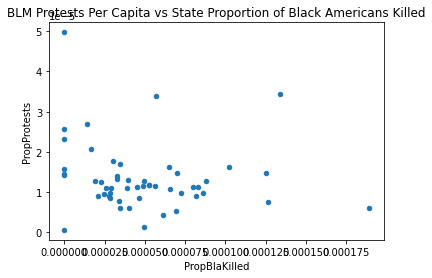

In [ ]:
dfB.plot.scatter(x='PropBlaKilled', y='PropProtests',
                        title='BLM Protests Per Capita vs State Proportion of Black Americans Killed')

The above plot doesn't have a clear enough trend for us to say that population size itself is impacting the number of protests. In some cases a very low proportion of Black Americans killed relates to a very high number of BLM protests adjusted for population while in other cases a very high proportion of Black Americans killed relates to a very low number of BLM protests adjusted for population. In the next section we will attempt to delve deeper into what different features of a state may help us predict how involved the state's population is in the BLM protests.

# **Part 3: Hypothesis Testing and Machine Learning**

In order to learn more about our dataset and what features influence others, we are going to dive into some hypothesis testing and machine learning. In general, we found two questions intriguing to us, which is what the focus of our machine learning models will be:
1. Can we predict the number of protests in a state? 
2. Can we predict the number of Black Americans killed after the protests began?

These are difficult questions to tackle and require us to take a step back before actually creating any models. First, we are going to have to wrangle the data some more so that we can separate killings pre and post June 2020 (the start of BLM protests). This will not only provide the values we want to predict for question 2, but also provide a potential predictor for question 1. Secondly, we need to actually determine which columns or features will be useful in predicting these two values. In order to do this, we will be making use of Pearson's correlation coefficient to ensure that whatever predictors we use are decently correlated with the values we want to predict.

First, we'll create a copy of our dfB dataframe into ml_data for further manipulation.

In [ ]:
# remove Puerto Rico as we are focusing on US and has NaN entries
ml_data = dfB.copy()
ml_data = ml_data.loc[ml_data['State'] != 'Puerto Rico']
ml_data.head()

,State,StateCode,Black,Pop,total_killed,NumBlaKilled,PropBlaKilled,Num_Protests,PropProtests
0,California,CA,0.0552,39613493,455.0,158.0,0.000072,387,0.000010
1,Florida,FL,0.1532,21944577,327.0,135.0,0.000040,135,0.000006
2,Texas,TX,0.1178,29730311,332.0,121.0,0.000035,184,0.000006
3,Georgia,GA,0.3118,10830007,193.0,95.0,0.000028,93,0.000009
4,Ohio,OH,0.1223,11714618,169.0,71.0,0.000050,149,0.000013


Next, we want to add a column to get the number of Black Americans killed prior to the 2020 BLM Protests which began in June 2020. This can be used to see if the number of Black Americans killed in a state prior to June 2020 is correlated with how many protests occurred in the state.

In [ ]:
shootingdf['date']=pd.to_datetime(shootingdf['date'])
cond1=(shootingdf['race']=="Black")
pre2020_date = "2020-5-31"
pre2020=(shootingdf['date'] <= pre2020_date) & (cond1)
pre2020=shootingdf.loc[pre2020]

statepre2020=pre2020.groupby(['state'])
pre2020bk=statepre2020.size().to_frame(name = 'BlaKilledPre2020').reset_index()
pre2020bk=pre2020bk.rename(columns={"state": "StateCode"}, errors="raise")
ml_data=pd.merge(ml_data, pre2020bk, on=["StateCode"])
ml_data.head()

,State,StateCode,Black,Pop,total_killed,NumBlaKilled,PropBlaKilled,Num_Protests,PropProtests,BlaKilledPre2020
0,California,CA,0.0552,39613493,455.0,158.0,0.000072,387,0.000010,125
1,Florida,FL,0.1532,21944577,327.0,135.0,0.000040,135,0.000006,112
2,Texas,TX,0.1178,29730311,332.0,121.0,0.000035,184,0.000006,101
3,Georgia,GA,0.3118,10830007,193.0,95.0,0.000028,93,0.000009,74
4,Ohio,OH,0.1223,11714618,169.0,71.0,0.000050,149,0.000013,56


Finally, we want to add a column to get the number of Black Americans killed during and after the 2020 BLM Protests which began in June 2020. This can be used to see if the number of protests occurred in the state had any affect on the number of Black Americans killed in that state.

In [ ]:
cond1=(shootingdf['race']=="Black")
post2020_date = "2020-6-1"
post2020=(shootingdf['date'] >= post2020_date) & (cond1)
post2020=shootingdf.loc[post2020]
post2020.head()

statepost2020=post2020.groupby(['state'])
post2020bk=statepost2020.size().to_frame(name = 'BlaKilledPost2020').reset_index()
post2020bk=post2020bk.rename(columns={"state": "StateCode"}, errors="raise")
post2020bk.head()
ml_data=pd.merge(ml_data, post2020bk, on=["StateCode"])
ml_data.head()

,State,StateCode,Black,Pop,total_killed,NumBlaKilled,PropBlaKilled,Num_Protests,PropProtests,BlaKilledPre2020,BlaKilledPost2020
0,California,CA,0.0552,39613493,455.0,158.0,0.000072,387,0.000010,125,33
1,Florida,FL,0.1532,21944577,327.0,135.0,0.000040,135,0.000006,112,23
2,Texas,TX,0.1178,29730311,332.0,121.0,0.000035,184,0.000006,101,20
3,Georgia,GA,0.3118,10830007,193.0,95.0,0.000028,93,0.000009,74,21
4,Ohio,OH,0.1223,11714618,169.0,71.0,0.000050,149,0.000013,56,15


Now that we're done wrangling our machine learning data, we can begin tackling our big questions. First, we want to answer the question, "can we predict the number of protests each state will have?" To start, we want to see what factors are correlated with the number of protests. We utilize Pearson's correlation coefficients and will look at factors that have a 0.70 or higher correlation coefficient with the number of protests. This way, we know that we using predictors that are correlated well with number of protests to increase our chances of a good model.

The factors we will consider for the pearson's coefficient are percentage of Black in the state, population of the state, and number of Black killed prior to the BLM protests. We thought that these would be interesting factors to focus on because they are directly related to the Black Americans that the protests are focusing on and also impact the number of Black Americans that are present in each state. Let's take a look at their pearson's coefficient now.

In [ ]:
print("Pearson's correlation coefficient between the number of protests and percent of black people in a state = "+ str(ml_data.corr().loc['Black','Num_Protests']))
print("Pearson's correlation coefficient between the number of protests and the population of a state = "+ str(ml_data.corr().loc['Pop','Num_Protests']))
print("Pearson's correlation coefficient between the number of protests and number of black people killed prior to the BLM Protests = "+ str(ml_data.corr().loc['BlaKilledPre2020','Num_Protests']))


Pearson's correlation coefficient between the number of protests and percent of black people in a state = -0.1518060344581629
Pearson's correlation coefficient between the number of protests and the population of a state = 0.8954824933134282
Pearson's correlation coefficient between the number of protests and number of black people killed prior to the BLM Protests = 0.7046090727415739


From what we see above, the population of a state and the number of Black killed per state (since 2015) prior to the protests have coefficients higher than 0.70. We deemed this as a high enough correlation coefficient to be useful as predictors in our machine learning models.

Now that we know what predictors we would like to use for predicting the number of BLM protests for each state, we can put this to use in a decision tree model. Decision trees use the predictors that we input to create nodes that force the model to make decisions - do I go left or right? Depending on how input values compare to the decision tree nodes, the input will eventually reach a leaf node that contains the predicted value for that input. Here, we will create a decision tree that takes in the number of Black killed prior to the 2020 protests as well as population as input and outputs the predicted number of protests. To read more about decision trees and how they are used in machine learning, visit this article: https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052.

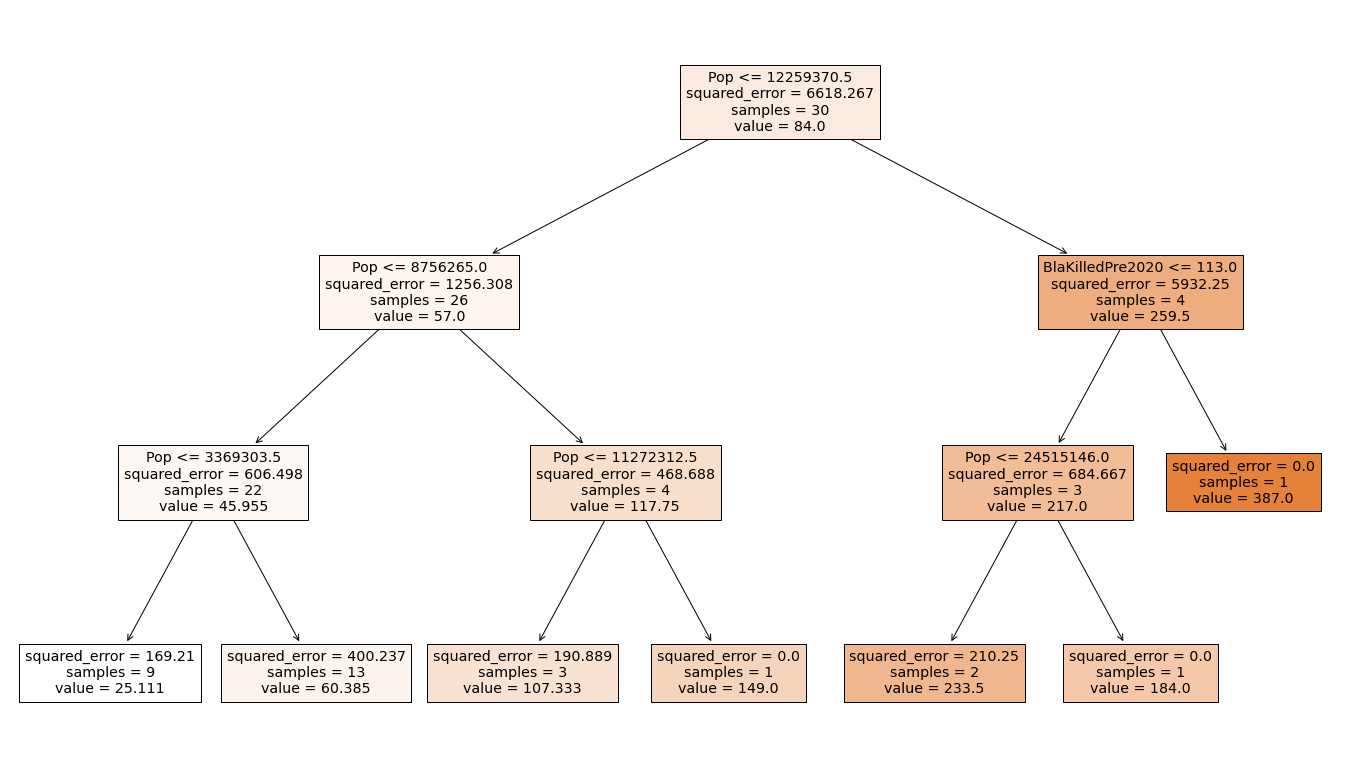

In [ ]:
#output value is number of protests
y = ml_data['Num_Protests']
#input values (predictors) are number of black killed pre 2020 protests and state population
x = ml_data[['BlaKilledPre2020', 'Pop']]

#split the data into a training dataset and testing (holdout) dataset
train_data, test_data, train_vals, test_vals = train_test_split(x, y, test_size = 0.2)

#select hyperparameters of max depth and min impurity decrease to help prevent overfitting the data
tree_model = tree.DecisionTreeRegressor(max_depth=3, min_impurity_decrease=0.3)
tree_model = tree_model.fit(train_data, train_vals)

plt.figure(figsize=(24, 14))
_ = tree.plot_tree(tree_model, feature_names=['BlaKilledPre2020', 'Pop'], filled=True)

Now that we have a decision tree model that we can use to predict number of protests, we want to evaluate the model's performance on both the training data as well as the testing data. In order to do so, we will look at two metrics: R^2 and the root mean squared error (RMSE). 

The R^2 value is called the coefficient of determination. This tells us how well our model accounts for variation in the dataset (how well does it predict the data?). The RMSE tells us something similar, it tells us how far our data lies from the model's regression - a larger RMSE means that the model's predictions are farther from the true values than a smaller RMSE.

We define the function get_results that computes the two values for both training and testing datasets below.

In [ ]:
def get_results(model, train_data, train_vals, test_data, test_vals):
  r2_train = model.score(train_data, train_vals)
  r2_test = model.score(test_data, test_vals)

  print(f"R^2 when predicting training data: {r2_train}")
  print(f"R^2 when predicting testing data: {r2_test}")

  pred_train = model.predict(train_data)
  pred_test = model.predict(test_data)

  rmse_train = np.sqrt(mean_squared_error(train_vals, pred_train))
  rmse_test = np.sqrt(mean_squared_error(test_vals, pred_test))

  print(f"RMSE when predicting training data: {rmse_train}")
  print(f"RMSE when predicting testing data: {rmse_test}")

get_results(tree_model, train_data, train_vals, test_data, test_vals)

R^2 when predicting training data: 0.9181789587003617
R^2 when predicting testing data: 0.5021589974234015
RMSE when predicting training data: 17.54470480420422
RMSE when predicting testing data: 81.3819868138999


Keep in mind that when running this tutorial over again, different datasets for training and testing will be created from the call to train_test_split when we first created out two datasets. This could yield different results from the ones are writing about here and for the rest of the models.

At the time of writing this, we saw that the R^2 for predicting training data was 0.91 and for testing data was 0.50. This means that our model accounts for variation in the dataset fairly well for the training data, but doesn't do as well for the testing dataset. For the RMSE, the model produced a RMSE of 17.54 for the training dataset and 81.38 for the testing dataset. Again, this shows that although our decision tree model did well in predicting the training dataset, its performance diminished when it came to predicting the testing dataset.

What are some ways that we can try to improve upon this model? We will see if we can get an improved model by creating a Random Forest model which builds on deicison trees. Random forest models utilize the generation of many decision trees based on bootstrapped datasets in an attempt to better account for variation in the dataset. By creating many different trees, the predicted value takes into account the values produced by all of these and outputs a predicted value that is meant to be less biased. To read more about random forests, visit this website: https://towardsdatascience.com/understanding-random-forest-58381e0602d2.

Below, we will use the same training and testing dataset (for better comparison of models), but instead generate a Random Forest Regressor model. We will again use the same metrics for evaluation as we did with the decision tree model.

In [ ]:
#create random forest model with 50 trees
#same max depth and min impurity decrease as before
rf_model = RandomForestRegressor(n_estimators=50, max_depth=3, min_impurity_decrease=0.3)
rf_model = rf_model.fit(train_data, train_vals)

get_results(rf_model, train_data, train_vals, test_data, test_vals)

R^2 when predicting training data: 0.9305418184701413
R^2 when predicting testing data: 0.5402540572537506
RMSE when predicting training data: 16.164983617051703
RMSE when predicting testing data: 78.20633062179


At the time of writing this, the R^2 for the training dataset was 0.93 while the R^2 for the testing dataset was 0.54. You can see that this is a slight increase from what we saw with just the one decision tree. Similarly, there was a slight improvement in RMSE with 16.16 for the training dataset and 78.21 for the testing dataset.

Next, we wanted to see if we could predict, "how many Black Americans have been killed since the beginning of the BLM protests in each state?" In order to do this, we will again look at factors that we think might have an impact on this and evaluate them with Pearson's correlation coefficient, taking factors with a correlation coefficient of >= 0.70 as predictors for our model.

The factors that we will consider for Pearson's coefficient are the number of BLM protests and total number of people killed. We wanted to look at these because we want to see if the BLM protests could be indicative of the number of Black killings during and following (are these related and if so, do more protests indicate fewer killings). Additionally, the total number killed is directly related to the number of Black killed since June 2020 and could be a useful baseline for our model.

We'll take a look at the Pearson's coefficient for these factors to see if they correlate with the number of Black killed since June 2020 (when the BLM protests began).

In [ ]:
print("Pearson's correlation coefficient between the number of protests and number of black people killed since June 2020 = "+ str(ml_data.corr().loc['BlaKilledPost2020','Num_Protests']))
print("Pearson's correlation coefficient between total number of people killed and number of black people killed since June 2020 = "+ str(ml_data.corr().loc['BlaKilledPost2020','total_killed']))

Pearson's correlation coefficient between the number of protests and number of black people killed since June 2020 = 0.7054100634727407
Pearson's correlation coefficient between total number of people killed and number of black people killed since June 2020 = 0.8771929987122914


From what we see above, both the number of protests and the total number killed have coefficients higher than 0.70. With this information, we can construct a decision tree again, but for these predictors and the predicted value of number of Black killed after the protests began.

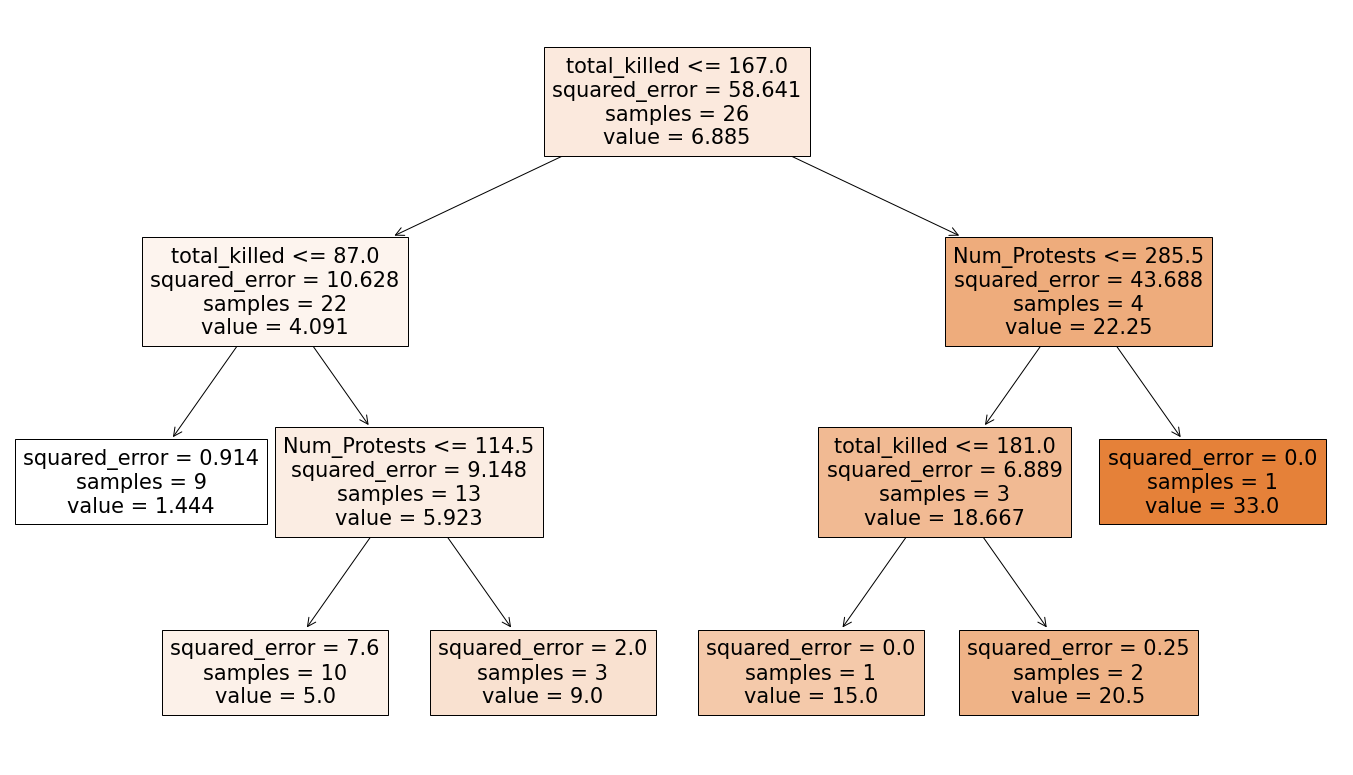

In [ ]:
#output value is number of black killed post June 2020
y = ml_data['BlaKilledPost2020']
#input values (predictors) are number of total killed and number of protests
x = ml_data[['total_killed', 'Num_Protests']]

#split the data into a training dataset and testing (holdout) dataset
train_data, test_data, train_vals, test_vals = train_test_split(x, y, test_size = 0.3)

#select hyperparameters of max depth and min impurity decrease to help prevent overfitting the data
tree_model = tree.DecisionTreeRegressor(max_depth=3, min_impurity_decrease=0.3)
tree_model = tree_model.fit(train_data, train_vals)

plt.figure(figsize=(24, 14))
_ = tree.plot_tree(tree_model, feature_names=['total_killed', 'Num_Protests'], filled=True)

Again, we will evaluate this model based on the same metrics we did previously.

In [ ]:
get_results(tree_model, train_data, train_vals, test_data, test_vals)

R^2 when predicting training data: 0.9404965117484984
R^2 when predicting testing data: 0.800818016477668
RMSE when predicting training data: 1.867971155911204
RMSE when predicting testing data: 2.472326256654158


At the time of writing this, the model yielded R^2 of 0.94 for the training dataset and 0.80 for the testing dataset. The RMSE values were 1.87 for the training dataset and 2.47 for the testing dataset. One reason why the RMSE values are likely so low is that the range of the number of Black Americans killed post June 2020 is not nearly as large as say, the number of protests in the states. This means that the predictions likely won't deviate as much. However, we do see that the model, while not perfect, is doing pretty well at predicting the training dataset and is doing a decent job at predicting the testing dataset as we see based on the R^2.

And again, we will create another random forest model for these predictors.

In [ ]:
#create random forest model with 50 trees
#same max depth and min impurity decrease as before
rf_model = RandomForestRegressor(n_estimators = 50, max_depth=3, min_impurity_decrease=0.3)
rf_model = rf_model.fit(train_data, train_vals)

get_results(rf_model, train_data, train_vals, test_data, test_vals)

R^2 when predicting training data: 0.9163684667248788
R^2 when predicting testing data: 0.7196093840867496
RMSE when predicting training data: 2.21454231134924
RMSE when predicting testing data: 2.933340591516415


Interestingly enough, at the time of writing this, the performance of the random forest model seemed to do a slightly worse job than our decision tree model. The R^2 for predicting the training data was 0.91 while for predicting the testing data was 0.71, a decrease from before. In addition to this, the RMSE for the training data was 2.21 while for the testing data it was 2.93, a slight increase from our decision tree model.

# **Final Notes**

To summarize this tutorial, we began by looking at datasets with police shooting data from 2015-2021, state total populations and the percent each race makes up of the population, and BLM protest data from June 2020 to November 2020.

We first looked at all the races and the proportion of them being killed in police shootings per state based on their makeup of each state. We found that Black Americans across states were being killed in police shootings at significantly higher proportions than Asian and White Americans (and similar or higher proportions than Native Americans).

We then narrowed our focus on Black Americans being killed in police shootings per state as well as the population of Black Americans per state and seeing how it relates to the number of BLM protests that went on in the state. We found that just because a state had a high proportion of Black Americans killed in Police shootings or high proportion of Black Americans making up the state, doesn't mean the number of protests would be high.

We next wanted to see if there was any way we could have predicted the number of protests that would occur in a state and if there was any way we could predicted the number of Black Americans that were killed by police shootings per state in the time following the protests. We wanted to look into these questions to get an idea if the number of BLM protests per state was a direct response to the number of Black Americans killed in the state and more importantly, to get an idea of whether the number of BLM protests in a state has resulted in lower numbers of police shootings of Black Americans in that state compared to other states.

What we found while working through these two prediction questions was that there were certain features that correlated well with our values to be predicted. For predicting the number of protests, we found that the number of Black killed in the state before the 2020 protests and the state population were correlated well, and thus we used them as predictors for our model. For predicting the number of Black killed following the start of the protests in 2020, we found that the total number of people killed and the number of protests correlated well, so we used these as our predictors for this model. In both cases, we create decision tree models and random forest models and saw that they had diminished performance on test data compared to training data. However, it is a good start for models that could be improved upon in the future.

Future analysis as more time passes from the 2020 BLM protests and the BLM movement develops further would be interesting. It would also be interesting to look into how critical events of Native American civil rights movements have related to the high proportion of Native Americans being  killed in police shootings.